# **Sentiment Analysis II - Active Learning**
So far we have tried:
- roberta pre trained
- zero shot learning
- Vader on translated tweets

Issue: none of them works well (not good classification and very imbalanced data).

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

In [2]:
os.environ['WANDB_DISABLED'] = 'true'

## **Load the Data**

In [15]:
politicians_cleaned = pd.read_csv('politicians_classified.csv')
data = politicians_cleaned.drop(columns=['Unnamed: 0', 'classification'])

In [3]:
labeled_data = pd.read_csv('labeled_tweets_with_tone.csv')

## **Active Learning**
Active learning is a technique used to minimize labeling effort by selectively choosing which examples a human should label next.
How it works:
- Start with a small labeled set (e.g., 200 tweets).
- Train an initial model (using transfer learning).
- Use that model to predict on the unlabeled tweets.
- Select the most uncertain predictions (e.g., low confidence margin between classes).
- Manually label these tweets (they’re the most informative).
- Retrain the model with the new labeled data.
- Repeat 
Goal: Reach high model performance with far fewer labels than random sampling would require

SET OF LABELS:

    'Call to Action / Propaganda': 0,

    'Critical / Angry': 1,

    'Neutral / Informational': 2,

    'Supportive / Affirmative / Celebratory': 4

We start with 200 manually labeled tweets stored in labeled data.

In [ ]:
unlabeled_data = data[~data['Content'].isin(labeled_data['Content'])]

### **Fine Tune**

In [ ]:
model_name = "dbmdz/bert-base-italian-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [19]:
label_list = labeled_data['tone_label'].unique()
label2id = {label: idx for idx, label in enumerate(label_list)}
id2label = {idx: label for label, idx in label2id.items()}

labeled_data['label_id'] = labeled_data['tone_label'].map(label2id)

from datasets import Dataset

train_dataset = Dataset.from_pandas(labeled_data)

def tokenize_function(examples):
    return tokenizer(examples['Content'], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
train_dataset = train_dataset.rename_column("label_id", "labels")

columns_to_remove = [col for col in train_dataset.column_names if col not in ['input_ids', 'attention_mask', 'labels']]
train_dataset = train_dataset.remove_columns(columns_to_remove)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map: 100%|██████████| 700/700 [00:00<00:00, 2847.84 examples/s]


In [20]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    logging_steps=10,
    save_steps=100,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

print("Starting fine-tuning on labeled data...")
trainer.train()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Using the `WANDB_DISABLED` e

Starting fine-tuning on labeled data...


Step,Training Loss
10,1.534200
20,1.592300
30,1.500000
40,1.451900
50,1.442400
60,1.556800
70,1.456300
80,1.487100
90,1.465000
100,1.398300


TrainOutput(global_step=264, training_loss=1.1528323563662441, metrics={'train_runtime': 187.2258, 'train_samples_per_second': 11.216, 'train_steps_per_second': 1.41, 'total_flos': 552548099174400.0, 'train_loss': 1.1528323563662441, 'epoch': 3.0})

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# SAMPLE SUBSET FOR FASTER INFERENCE
subset_size = 5000
sampled_unlabeled_data = unlabeled_data.sample(n=subset_size).reset_index(drop=True)
inference_dataset = Dataset.from_pandas(sampled_unlabeled_data)
inference_dataset = inference_dataset.map(tokenize_function, batched=True)
inference_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])
inference_loader = DataLoader(inference_dataset, batch_size=16)
model.eval()
all_probs = []
all_pred_labels = []  

print(f"Performing inference on {subset_size} sampled tweets...")
with torch.no_grad():
    for batch in tqdm(inference_loader):
        batch = {key: value.to(device) for key, value in batch.items()}
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        max_probs, predicted = probs.max(dim=-1) 
        all_probs.extend(max_probs.cpu().numpy())
        all_pred_labels.extend(predicted.cpu().numpy())  




Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map: 100%|██████████| 5000/5000 [00:02<00:00, 2035.28 examples/s]


Performing inference on 5000 sampled tweets...


100%|██████████| 313/313 [02:31<00:00,  2.06it/s]


In [ ]:
uncertainties = 1 - np.array(all_probs)
uncertain_indices = np.argsort(uncertainties)[-100:]
uncertain_samples = sampled_unlabeled_data.iloc[uncertain_indices] 

certain_indices = np.argsort(uncertainties)[:10] 
certain_samples = sampled_unlabeled_data.iloc[certain_indices]

print("\n10 Most Certain Predictions:")
for i, (idx, row) in enumerate(certain_samples.iterrows()):
    predicted_label_id = all_pred_labels[certain_indices[i]]
    confidence = all_probs[certain_indices[i]]
    
    label_name = id2label[predicted_label_id]
    
    if 'content' in row:
        tweet_content = row['content']
    elif 'text' in row:
        tweet_content = row['text']
    else:
        text_columns = [col for col in row.index if any(x in col.lower() for x in ['content', 'text', 'tweet'])]
        tweet_content = row[text_columns[0]] if text_columns else "Content not found"
    
    tweet_display = tweet_content[:100] + "..." if len(tweet_content) > 100 else tweet_content
    
    print(f"{i+1}. Predicted: {label_name} (confidence: {confidence:.4f})")
    print(f"   Tweet: {tweet_display}")
    print()


10 Most Certain Predictions:
1. Predicted: Critical / Angry (confidence: 0.9291)
   Tweet: @ErranteItaliano Siamo disabituati a ragionamenti complessi. E infatti tu non rispondi sul merito. D...

2. Predicted: Critical / Angry (confidence: 0.9285)
   Tweet: Le allodole e lo specchio distorto dei Partiti. Come destra e sinistra stanno prendendo in giro i ci...

3. Predicted: Critical / Angry (confidence: 0.9276)
   Tweet: Più dei cinghiali quello che trovo indegno è l’apertura contemporanea e a casaccio di cantieri nell’...

4. Predicted: Critical / Angry (confidence: 0.9266)
   Tweet: Ecco il vergognoso risultato di norme folli che - in determinati casi - rasentano la disumanità. Il ...

5. Predicted: Critical / Angry (confidence: 0.9265)
   Tweet: Le votazioni iniziano con quasi 2h di ritardo. Prima bloccati a aspettare le FOTOCOPIE,
poi la maggi...

6. Predicted: Critical / Angry (confidence: 0.9260)
   Tweet: La sinistra odia le piscine. E reprime la libertà di nuotare. Il perché n

In [ ]:
average_uncertainty = np.mean(uncertainties)
n_labeled = len(labeled_data)

print(f"\nAverage uncertainty over unlabeled data: {average_uncertainty:.4f}")

log_line = f"Labeled samples: {n_labeled}, Average uncertainty: {average_uncertainty:.4f}\n"
with open('uncertainty_tracking.txt', 'a') as f:
    f.write(log_line)


Average uncertainty over unlabeled data: 0.3551


In [25]:
uncertain_samples.to_csv('next_batch_to_label.csv', index=False)

Once we get here, we should label the next batch using <code>interactive_labeling.py</code>. Then repeat the script from the start. 

Once we reach 700 labeled samples, the uncertainty has significantly dropped so we stop. Now, we perform inference on the whole corpus.

In [ ]:
inference_dataset = Dataset.from_pandas(unlabeled_data.reset_index(drop=True))

inference_dataset = inference_dataset.map(tokenize_function, batched=True)
inference_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

inference_loader = DataLoader(inference_dataset, batch_size=16)

model.eval()
all_probs = []
all_pred_labels = []

print(f"Performing inference on {len(unlabeled_data)} tweets...")
with torch.no_grad():
    for batch in tqdm(inference_loader):
        batch = {key: value.to(device) for key, value in batch.items()}
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        max_probs, predicted = probs.max(dim=-1)
        all_probs.extend(max_probs.cpu().numpy())
        all_pred_labels.extend(predicted.cpu().numpy())

inference_results = unlabeled_data.copy()
inference_results['predicted_label'] = all_pred_labels
inference_results['confidence'] = all_probs

pseudo_labeled_data = inference_results[inference_results['confidence'] >= 0.9].reset_index(drop=True)

print(f"\nNumber of pseudo-labeled tweets with >90% confidence: {len(pseudo_labeled_data)}")


Map:   0%|          | 0/16545 [00:00<?, ? examples/s]

Map: 100%|██████████| 16545/16545 [00:05<00:00, 2959.99 examples/s]


Performing inference on 16545 tweets...


100%|██████████| 1035/1035 [08:23<00:00,  2.06it/s]


Number of pseudo-labeled tweets with >90% confidence: 578


In [27]:
uncertainties = 1 - np.array(all_probs)
average_uncertainty = np.mean(uncertainties)

print(f"\nAverage uncertainty over full data: {average_uncertainty:.4f}")


Average uncertainty over full data: 0.3539


In [28]:
training_data = pseudo_labeled_data.drop(columns='confidence').rename(columns={'predicted_label':'label_id'})

In [29]:
new_train_data = pd.concat([training_data, labeled_data.drop(columns='tone_label')])

Now we repeat training on the whole file.

In [31]:
label_list = new_train_data['label_id'].unique()

from datasets import Dataset

train_dataset = Dataset.from_pandas(new_train_data)

def tokenize_function(examples):
    return tokenizer(examples['Content'], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
train_dataset = train_dataset.rename_column("label_id", "labels")

columns_to_remove = [col for col in train_dataset.column_names if col not in ['input_ids', 'attention_mask', 'labels']]
train_dataset = train_dataset.remove_columns(columns_to_remove)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


Map:   0%|          | 0/1278 [00:00<?, ? examples/s]

Map: 100%|██████████| 1278/1278 [00:00<00:00, 2793.23 examples/s]


## **Final Step**

In [ ]:
label_list = labeled_data['tone_label'].unique()

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    logging_steps=50,
    save_steps=100,
    save_total_limit=2, 
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

print("Starting fine-tuning on labeled data...")
trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Starting fine-tuning on labeled data...


Step,Training Loss
50,1.295700
100,0.997400
150,0.825700
200,0.745400
250,0.639100
300,0.612400
350,0.453300
400,0.331200
450,0.360000


TrainOutput(global_step=480, training_loss=0.674830025434494, metrics={'train_runtime': 377.8819, 'train_samples_per_second': 10.146, 'train_steps_per_second': 1.27, 'total_flos': 1008794958206976.0, 'train_loss': 0.674830025434494, 'epoch': 3.0})

Finally, we perform inference on the whole data using the trained model above and we keep only samples with confidence higher than 80%

In [33]:
unlabeled_data = data[~data['Content'].isin(new_train_data['Content'])]
inference_dataset = Dataset.from_pandas(unlabeled_data.reset_index(drop=True))

inference_dataset = inference_dataset.map(tokenize_function, batched=True)
inference_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

inference_loader = DataLoader(inference_dataset, batch_size=16)

model.eval()
all_probs = []
all_pred_labels = []

print(f"Performing inference on {len(unlabeled_data)} tweets...")
with torch.no_grad():
    for batch in tqdm(inference_loader):
        batch = {key: value.to(device) for key, value in batch.items()}
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        max_probs, predicted = probs.max(dim=-1)
        all_probs.extend(max_probs.cpu().numpy())
        all_pred_labels.extend(predicted.cpu().numpy())

inference_results = unlabeled_data.copy()
inference_results['predicted_label'] = all_pred_labels
inference_results['confidence'] = all_probs

Map: 100%|██████████| 15967/15967 [00:05<00:00, 3017.70 examples/s]


Performing inference on 15967 tweets...


100%|██████████| 998/998 [08:05<00:00,  2.06it/s]


In [34]:
uncertainties = 1 - np.array(all_probs)
average_uncertainty = np.mean(uncertainties)

print(f"\nAverage uncertainty over full data with additional pseudo_labeled_examples: {average_uncertainty:.4f}")


Average uncertainty over full data with additional pseudo_labeled_examples: 0.2215


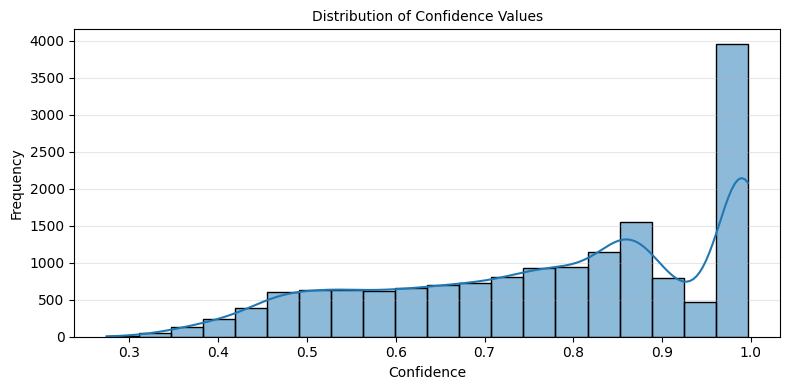

In [70]:
plt.figure(figsize=(8, 4))

sns.histplot(inference_results['confidence'], bins=20, kde=True)

plt.title('Distribution of Confidence Values', fontsize=10)
plt.xlabel('Confidence', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
predicted_data = inference_results[inference_results['confidence'] >= 0.80].reset_index(drop=True)
print(f"\nNumber of pseudo-labeled tweets with >80% confidence: {len(predicted_data)}")


Number of pseudo-labeled tweets with >80% confidence: 8328


In [81]:
final_labeled_df = pd.concat([new_train_data, predicted_data.rename(columns={'predicted_label':'label_id'})
                              .drop(columns='confidence')]) 

In [83]:
unlabeled_data = data[~data['Content'].isin(final_labeled_df['Content'])]
final_df = pd.concat([final_labeled_df, unlabeled_data])

In [ ]:
mapping = {
    1.0: 1,
    0.0: 0,
    2.0: 2,
    3.0: 3,
    4.0: 3
    }

final_df['label_id'] = final_df['label_id'].map(mapping)

final_df['label_id'] = final_df['label_id'].fillna('unknown')

print("\nCounts of each mapped value:")
print(final_df['label_id'].value_counts(dropna=False))



Counts of each mapped value:
label_id
unknown    7639
1.0        5697
0.0        1754
3.0        1249
2.0         906
Name: count, dtype: int64


In [91]:
final_df.to_csv('final_tone_labeled_data.csv')